In [1]:
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
import time
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class ContentDataset(Dataset):
    def __init__(self, content_dir, image_size = 512, transform=None, max_images=None):
        self.content_paths = [os.path.join(content_dir, fname)
                              for fname in os.listdir(content_dir)
                              if fname.lower().endswith(('jpg', 'png'))]
        if max_images:
            self.content_paths = self.content_paths[:max_images]

        self.transform = transform or transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.content_paths)

    def __getitem__(self, idx):
        content_image = Image.open(self.content_paths[idx]).convert('RGB')
        return self.transform(content_image)
    
def load_and_preprocess(image_path, image_size=512, device='cuda'):
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor()
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0).to(device)  # shape: [1, C, H, W]



In [4]:
# Hyperparameters
batch_size = 4
max_images = 1000

# Data
content_dir = "COCO"
style_tensor = load_and_preprocess('picasso.jpg').to(device)

content_dataset = ContentDataset(content_dir, max_images=max_images)
dataloader = DataLoader(content_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [5]:
def calc_mean_std(feat, eps=1e-5):
    # eps is a small value added to the variance to avoid divide-by-zero.
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std


def adaptive_instance_normalization(content_feat, style_feat):
    assert (content_feat.size()[:2] == style_feat.size()[:2])
    size = content_feat.size()
    style_mean, style_std = calc_mean_std(style_feat)
    content_mean, content_std = calc_mean_std(content_feat)

    normalized_feat = (content_feat - content_mean.expand(
        size)) / content_std.expand(size)
    return normalized_feat * style_std.expand(size) + style_mean.expand(size)


def _calc_feat_flatten_mean_std(feat):
    # takes 3D feat (C, H, W), return mean and std of array within channels
    assert (feat.size()[0] == 3)
    assert (isinstance(feat, torch.FloatTensor))
    feat_flatten = feat.view(3, -1)
    mean = feat_flatten.mean(dim=-1, keepdim=True)
    std = feat_flatten.std(dim=-1, keepdim=True)
    return feat_flatten, mean, std


def _mat_sqrt(x):
    U, D, V = torch.svd(x)
    return torch.mm(torch.mm(U, D.pow(0.5).diag()), V.t())


def coral(source, target):
    # assume both source and target are 3D array (C, H, W)
    # Note: flatten -> f

    source_f, source_f_mean, source_f_std = _calc_feat_flatten_mean_std(source)
    source_f_norm = (source_f - source_f_mean.expand_as(
        source_f)) / source_f_std.expand_as(source_f)
    source_f_cov_eye = \
        torch.mm(source_f_norm, source_f_norm.t()) + torch.eye(3)

    target_f, target_f_mean, target_f_std = _calc_feat_flatten_mean_std(target)
    target_f_norm = (target_f - target_f_mean.expand_as(
        target_f)) / target_f_std.expand_as(target_f)
    target_f_cov_eye = \
        torch.mm(target_f_norm, target_f_norm.t()) + torch.eye(3)

    source_f_norm_transfer = torch.mm(
        _mat_sqrt(target_f_cov_eye),
        torch.mm(torch.inverse(_mat_sqrt(source_f_cov_eye)),
                 source_f_norm)
    )

    source_f_transfer = source_f_norm_transfer * \
                        target_f_std.expand_as(source_f_norm) + \
                        target_f_mean.expand_as(source_f_norm)

    return source_f_transfer.view(source.size())

def style_transfer(vgg, decoder, content, style, alpha=1.0,
                   interpolation_weights=None, device='cuda'):
    assert (0.0 <= alpha <= 1.0)
    content_f = vgg(content)
    style_f = vgg(style)
    if interpolation_weights:
        _, C, H, W = content_f.size()
        feat = torch.FloatTensor(1, C, H, W).zero_().to(device)
        base_feat = adaptive_instance_normalization(content_f, style_f)
        for i, w in enumerate(interpolation_weights):
            feat = feat + w * base_feat[i:i + 1]
        content_f = content_f[0:1]
    else:
        feat = adaptive_instance_normalization(content_f, style_f)
    feat = feat * alpha + content_f * (1 - alpha)
    return decoder(feat)

In [6]:

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 256, (3, 3)),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, (3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, (3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, (3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 128, (3, 3)),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128, 128, (3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128, 64, (3, 3)),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64, 64, (3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64, 3, (3, 3)),
        )

    def forward(self, x):
        return self.model(x)
    
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 3, (1, 1)),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(3, 64, (3, 3)),
            nn.ReLU(),  # relu1-1
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64, 64, (3, 3)),
            nn.ReLU(),  # relu1-2
            nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64, 128, (3, 3)),
            nn.ReLU(),  # relu2-1
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128, 128, (3, 3)),
            nn.ReLU(),  # relu2-2
            nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128, 256, (3, 3)),
            nn.ReLU(),  # relu3-1
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, (3, 3)),
            nn.ReLU(),  # relu3-2
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, (3, 3)),
            nn.ReLU(),  # relu3-3
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, (3, 3)),
            nn.ReLU(),  # relu3-4
            nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 512, (3, 3)),
            nn.ReLU(),  # relu4-1, this is the last layer used
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  # relu4-2
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  # relu4-3
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  # relu4-4
            nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  # relu5-1
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  # relu5-2
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  # relu5-3
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU()  # relu5-4
        )

    def forward(self, x):
        return self.model(x)
    

class Net(nn.Module):
    def __init__(self, encoder, decoder):
        super(Net, self).__init__()
        enc_layers = list(encoder.children())
        self.enc_1 = nn.Sequential(*enc_layers[:4])  # input -> relu1_1
        self.enc_2 = nn.Sequential(*enc_layers[4:11])  # relu1_1 -> relu2_1
        self.enc_3 = nn.Sequential(*enc_layers[11:18])  # relu2_1 -> relu3_1
        self.enc_4 = nn.Sequential(*enc_layers[18:31])  # relu3_1 -> relu4_1
        self.decoder = decoder
        self.mse_loss = nn.MSELoss()

        # fix the encoder
        for name in ['enc_1', 'enc_2', 'enc_3', 'enc_4']:
            for param in getattr(self, name).parameters():
                param.requires_grad = False

    # extract relu1_1, relu2_1, relu3_1, relu4_1 from input image
    def encode_with_intermediate(self, input):
        results = [input]
        for i in range(4):
            func = getattr(self, 'enc_{:d}'.format(i + 1))
            results.append(func(results[-1]))
        return results[1:]

    # extract relu4_1 from input image
    def encode(self, input):
        for i in range(4):
            input = getattr(self, 'enc_{:d}'.format(i + 1))(input)
        return input

    def calc_content_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        return self.mse_loss(input, target)

    def calc_style_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        input_mean, input_std = calc_mean_std(input)
        target_mean, target_std = calc_mean_std(target)
        return self.mse_loss(input_mean, target_mean) + \
               self.mse_loss(input_std, target_std)

    def forward(self, content, style, alpha=1.0):
        assert 0 <= alpha <= 1
        style_feats = self.encode_with_intermediate(style)
        content_feat = self.encode(content)
        t = adaptive_instance_normalization(content_feat, style_feats[-1])
        t = alpha * t + (1 - alpha) * content_feat

        g_t = self.decoder(t)
        g_t_feats = self.encode_with_intermediate(g_t)

        loss_c = self.calc_content_loss(g_t_feats[-1], t)
        loss_s = self.calc_style_loss(g_t_feats[0], style_feats[0])
        for i in range(1, 4):
            loss_s += self.calc_style_loss(g_t_feats[i], style_feats[i])
        return loss_c, loss_s
    

In [7]:
decoder = Decoder()
decoder.load_state_dict(torch.load('checkpoints_picasso_from_scratch/decoder_epoch100.pth'))
decoder.train()

vgg = VGG()
vgg.model.load_state_dict(torch.load('../DLS_style_transfer_tg_bot/model_weights/vgg_normalised.pth'))
vgg = nn.Sequential(*list(vgg.model.children())[:31])
vgg.eval()


vgg.to(device)
decoder.to(device)

net = Net(vgg, decoder)
net.train()
net.to(device)
for param in vgg.parameters():
    param.requires_grad = False

In [8]:
num_epochs  = 100
lr          = 1e-4
content_weight = 1.0
style_weight   = 10.0
log_interval   = 10   # print every N batches
save_interval  = 10     # save every N epochs
checkpoint_dir = "./checkpoints_picasso_from_scratch_2"
os.makedirs(checkpoint_dir, exist_ok=True)
optimizer = optim.Adam(decoder.parameters(), lr=lr)


In [ ]:
epoch_content_losses = []
epoch_style_losses   = []

# pick one fixed pair for visualization
fixed_content = next(iter(dataloader))[0].unsqueeze(0).to(device)
fixed_content = fixed_content[0].unsqueeze(0).to(device)
fixed_style   = style_tensor[0].unsqueeze(0).to(device)

def tensor_to_pil(tensor):
    return transforms.ToPILImage()(tensor.clamp(0, 1))

for epoch in range(1, num_epochs + 1):
    t0 = time.time()
    epoch_c_loss = 0.0
    epoch_s_loss = 0.0
    n_batches    = 0

    for batch_idx, content_batch in enumerate(dataloader, 1):
        content_batch = content_batch.to(device)
        style_batch = style_tensor.expand_as(content_batch)

        optimizer.zero_grad()
        loss_c, loss_s = net(content_batch, style_batch, alpha=1.0)
        loss = content_weight * loss_c + style_weight * loss_s
        loss.backward()
        optimizer.step()

        epoch_c_loss += loss_c.item()
        epoch_s_loss += loss_s.item()
        n_batches    += 1

        if batch_idx % log_interval == 0:
            avg_c = epoch_c_loss / n_batches
            avg_s = epoch_s_loss / n_batches
            print(f"[Epoch {epoch}/{num_epochs}] "
                  f"[Batch {batch_idx}/{len(dataloader)}] "
                  f"content_loss: {avg_c:.4f}, style_loss: {avg_s:.4f}")

    # record epoch averages
    epoch_content_losses.append(epoch_c_loss / n_batches)
    epoch_style_losses.append(epoch_s_loss / n_batches)

    # epoch time
    elapsed = time.time() - t0
    print(f"→ Epoch {epoch} done in {int(elapsed//60)}m {int(elapsed%60)}s ▷ "
          f"avg_content: {epoch_content_losses[-1]:.4f}, avg_style: {epoch_style_losses[-1]:.4f}")

    # ------------
    #  Save checkpoint
    # ------------
    if epoch % save_interval == 0:
        path = os.path.join(checkpoint_dir, f"decoder_epoch{epoch}.pth")
        torch.save(decoder.state_dict(), path)
        print(f"  • Saved decoder to {path}")

    # ------------------------
    #  Visualization per epoch
    # ------------------------
    with torch.no_grad():
        output_vis = style_transfer(net.encode, decoder, fixed_content, fixed_style, alpha=1.0, device=device)
    output_vis = output_vis.cpu()

    c_img = tensor_to_pil(fixed_content.cpu()[0])
    s_img = tensor_to_pil(fixed_style.cpu()[0])
    o_img = tensor_to_pil(output_vis[0])

    plt.figure(figsize=(12, 4))
    for i, (img, title) in enumerate([(c_img, "Content"),
                                      (s_img, "Style"),
                                      (o_img, "Output")]):
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(f"Epoch {epoch}: {title}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

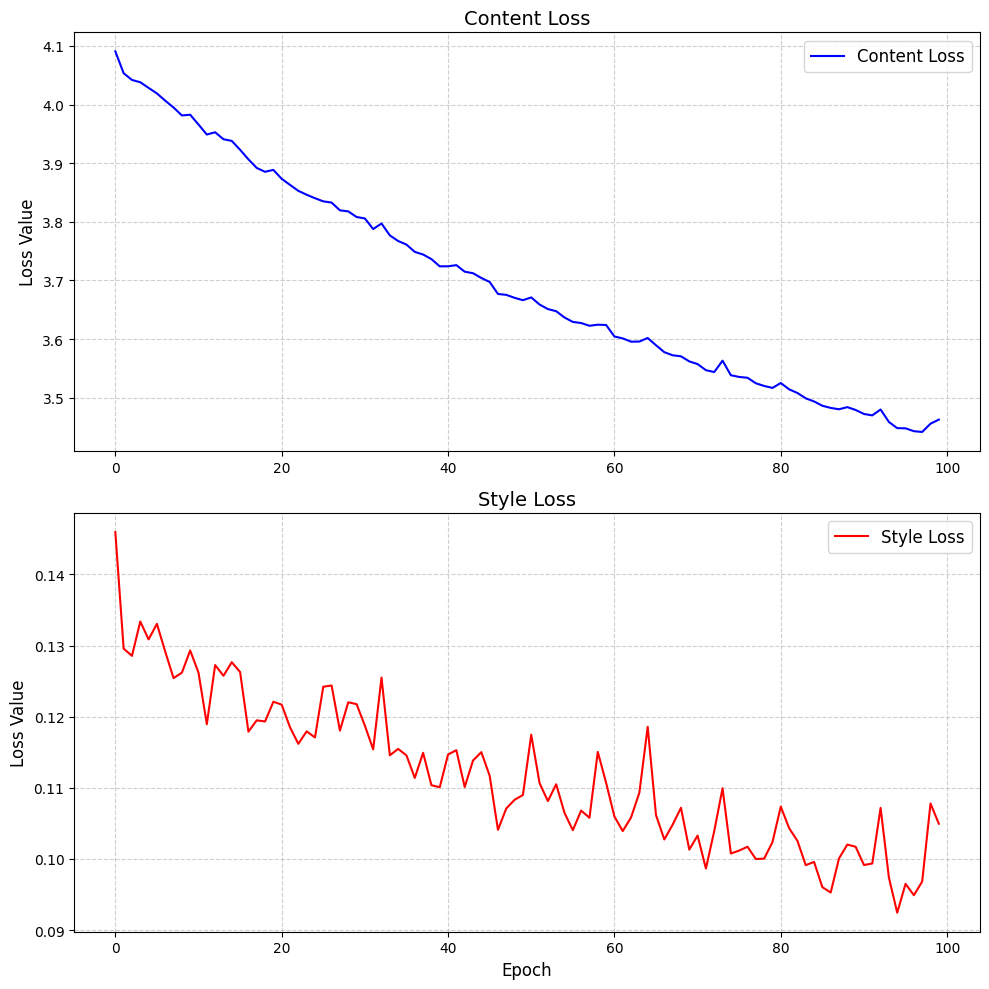

In [10]:
# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot content loss
ax1.plot(epoch_content_losses, label='Content Loss', color='blue')
ax1.set_title('Content Loss', fontsize=14)
ax1.set_ylabel('Loss Value', fontsize=12)
ax1.legend(fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)

# Plot style loss
ax2.plot(epoch_style_losses, label='Style Loss', color='red')
ax2.set_title('Style Loss', fontsize=14)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss Value', fontsize=12)
ax2.legend(fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.6)

# Adjust layout
plt.tight_layout()
plt.show()

In [11]:
decoder_baseline = Decoder()
decoder_baseline.model.load_state_dict(torch.load('../DLS_style_transfer_tg_bot/model_weights/decoder.pth'))
decoder_baseline.eval()

vgg_baseline = VGG()
vgg_baseline.model.load_state_dict(torch.load('../DLS_style_transfer_tg_bot/model_weights/vgg_normalised.pth'))
vgg_baseline = nn.Sequential(*list(vgg_baseline.model.children())[:31])
vgg_baseline.eval()


vgg_baseline.to(device)
decoder_baseline.to(device)

net_baseline = Net(vgg_baseline, decoder_baseline)
net_baseline.train()
net_baseline.to(device)

Net(
  (enc_1): Sequential(
    (0): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): ReflectionPad2d((1, 1, 1, 1))
    (2): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (enc_2): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
  )
  (enc_3): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
  )
  (enc_4): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(256, 256,

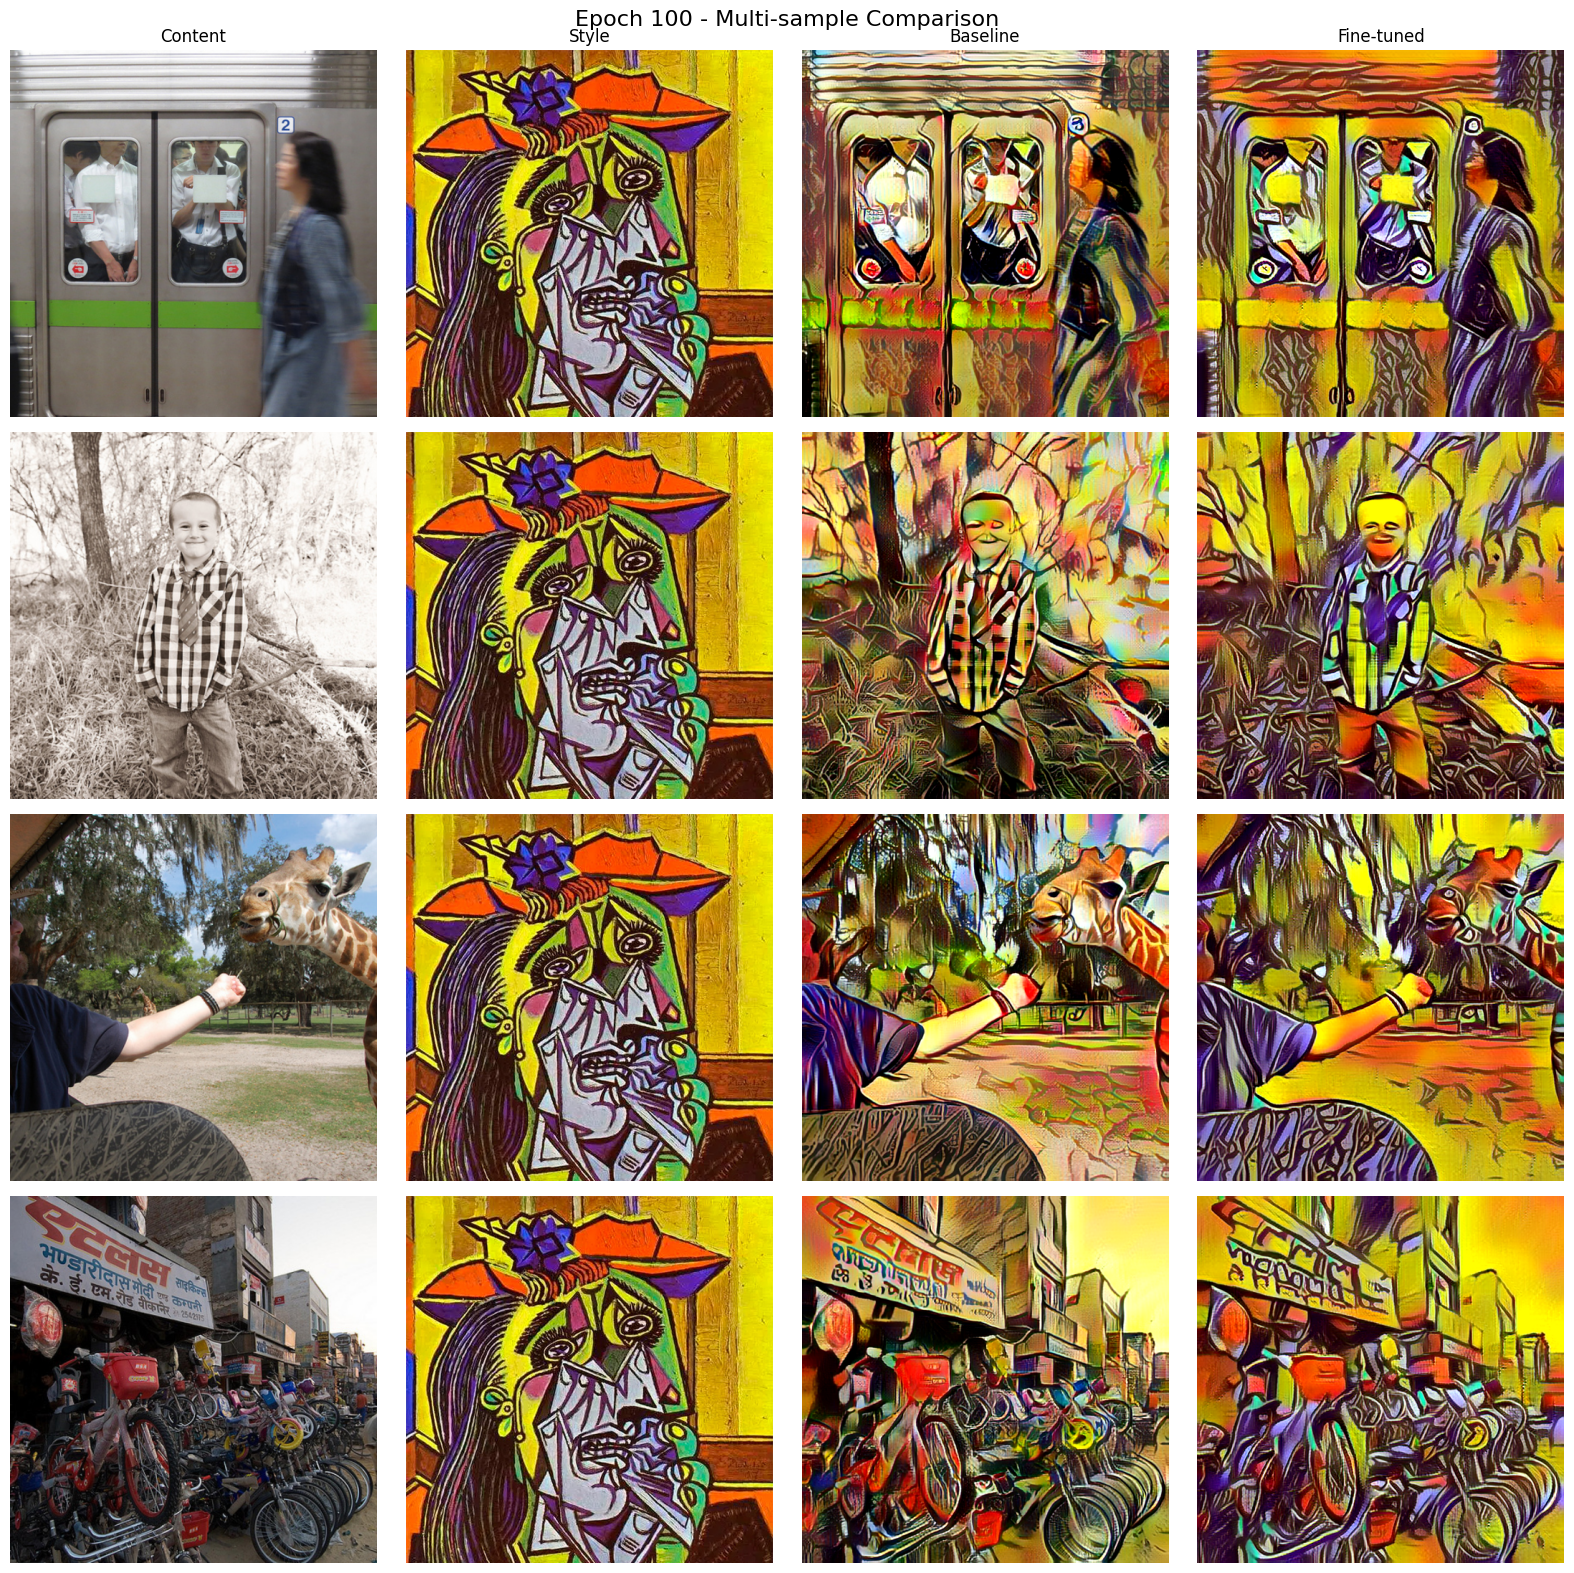

In [12]:
def generate_output(net, decoder, content, style, device, alpha=1.0):
    with torch.no_grad():
        return style_transfer(net.encode, decoder, content, style, alpha=alpha, device=device).cpu()

def plot_comparisons(content_tensors, style_tensor, outputs_baseline, outputs_finetuned, epoch):
    num_samples = len(content_tensors)
    plt.figure(figsize=(16, 4 * num_samples))

    for i in range(num_samples):
        imgs = [
            (tensor_to_pil(content_tensors[i].squeeze(0).cpu()), "Content"),
            (tensor_to_pil(style_tensor.cpu()), "Style"),
            (tensor_to_pil(outputs_baseline[i]), "Baseline"),
            (tensor_to_pil(outputs_finetuned[i]), "Fine-tuned")
        ]
        for j, (img, title) in enumerate(imgs):
            idx = i * 4 + j + 1
            plt.subplot(num_samples, 4, idx)
            plt.imshow(img)
            if i == 0:
                plt.title(title)
            plt.axis("off")

    plt.suptitle(f"Epoch {epoch} - Multi-sample Comparison", fontsize=16)
    plt.tight_layout()
    plt.show()

# --- Pick N content images ---
num_samples = 4
content_tensors = []
for i, content_batch in enumerate(dataloader):
    content_tensors.append(content_batch[0].unsqueeze(0).to(device))
    if len(content_tensors) == num_samples:
        break

# --- Generate outputs ---
outputs_baseline = []
outputs_finetuned = []

# Load baseline model
decoder_baseline = Decoder()
decoder_baseline.model.load_state_dict(torch.load('../DLS_style_transfer_tg_bot/model_weights/decoder.pth'))
decoder_baseline.eval().to(device)

vgg_baseline = VGG()
vgg_baseline.model.load_state_dict(torch.load('../DLS_style_transfer_tg_bot/model_weights/vgg_normalised.pth'))
vgg_baseline = nn.Sequential(*list(vgg_baseline.model.children())[:31])
vgg_baseline.eval().to(device)

net_baseline = Net(vgg_baseline, decoder_baseline).to(device)

for content_tensor in content_tensors:
    out_ft = generate_output(net, decoder, content_tensor, style_tensor, device)
    out_bl = generate_output(net_baseline, decoder_baseline, content_tensor, style_tensor, device)
    outputs_finetuned.append(out_ft[0])
    outputs_baseline.append(out_bl[0])

# --- Plot all rows ---
plot_comparisons(content_tensors, style_tensor[0], outputs_baseline, outputs_finetuned, epoch)
